In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

labels are in train/gt and images are in /train/images

In [3]:
path_lbl = '/home/jupyter/AerialImageDataset/train/labels'
path_img = '/home/jupyter/AerialImageDataset/train/images'
path_validate = '/home/jupyter/AerialImageDataset/train/validate'

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/AerialImageDataset/train/images/tyrol-w15.tif'),
 PosixPath('/home/jupyter/AerialImageDataset/train/images/tyrol-w6.tif'),
 PosixPath('/home/jupyter/AerialImageDataset/train/images/austin7.tif')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/AerialImageDataset/train/labels/vienna17_P.tif'),
 PosixPath('/home/jupyter/AerialImageDataset/train/labels/chicago29_P.tif'),
 PosixPath('/home/jupyter/AerialImageDataset/train/labels/vienna32_P.tif')]

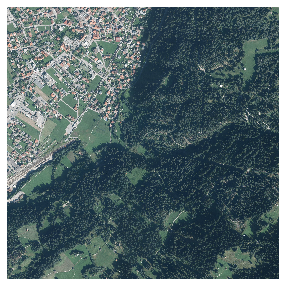

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
get_y_fn = lambda x: '{}/{}_P{}'.format(path_lbl, x.stem, x.suffix)

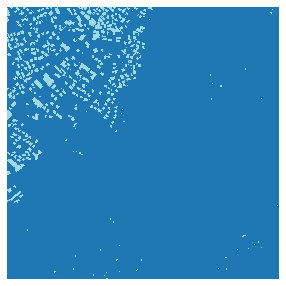

In [16]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5, ), alpha=1)

In [30]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([5000, 5000]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [35]:
size = src_size//16
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 3841MB of GPU RAM free


In [46]:
labels = [0, 255]

create a validation set by excluding the first five tiles of each area from the training set

In [47]:
src = (SegmentationItemList.from_folder('/home/jupyter/AerialImageDataset/train/')
      .split_by_folder(train='images', valid='validate')
      .label_from_func(get_y_fn, classes=labels))
src

LabelLists;

Train: LabelList (155 items)
x: SegmentationItemList
Image (3, 5000, 5000),Image (3, 5000, 5000),Image (3, 5000, 5000),Image (3, 5000, 5000),Image (3, 5000, 5000)
y: SegmentationLabelList
ImageSegment (1, 5000, 5000),ImageSegment (1, 5000, 5000),ImageSegment (1, 5000, 5000),ImageSegment (1, 5000, 5000),ImageSegment (1, 5000, 5000)
Path: /home/jupyter/AerialImageDataset/train;

Valid: LabelList (25 items)
x: SegmentationItemList
Image (3, 5000, 5000),Image (3, 5000, 5000),Image (3, 5000, 5000),Image (3, 5000, 5000),Image (3, 5000, 5000)
y: SegmentationLabelList
ImageSegment (1, 5000, 5000),ImageSegment (1, 5000, 5000),ImageSegment (1, 5000, 5000),ImageSegment (1, 5000, 5000),ImageSegment (1, 5000, 5000)
Path: /home/jupyter/AerialImageDataset/train;

Test: None

flip_vertical, max_lighting, max_zoom, max_warp as transformations along with default transformations provided by fastai.

In [48]:
data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (155 items)
x: SegmentationItemList
Image (3, 312, 312),Image (3, 312, 312),Image (3, 312, 312),Image (3, 312, 312),Image (3, 312, 312)
y: SegmentationLabelList
ImageSegment (1, 312, 312),ImageSegment (1, 312, 312),ImageSegment (1, 312, 312),ImageSegment (1, 312, 312),ImageSegment (1, 312, 312)
Path: /home/jupyter/AerialImageDataset/train;

Valid: LabelList (25 items)
x: SegmentationItemList
Image (3, 312, 312),Image (3, 312, 312),Image (3, 312, 312),Image (3, 312, 312),Image (3, 312, 312)
y: SegmentationLabelList
ImageSegment (1, 312, 312),ImageSegment (1, 312, 312),ImageSegment (1, 312, 312),ImageSegment (1, 312, 312),ImageSegment (1, 312, 312)
Path: /home/jupyter/AerialImageDataset/train;

Test: None

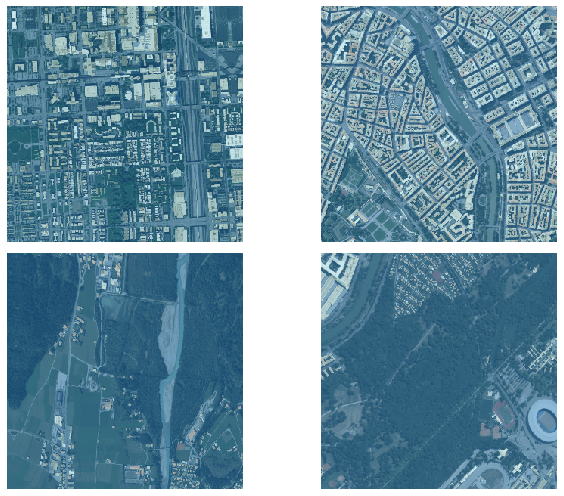

In [49]:
data.show_batch(2, figsize=(10,7))

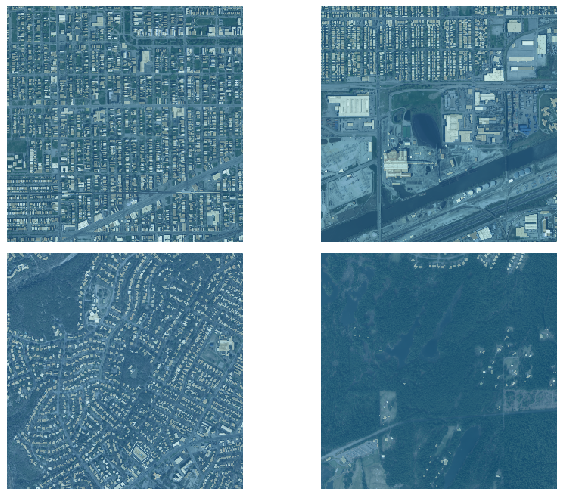

In [50]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [55]:
def dice(input:Tensor, targs:Tensor, iou:bool=True)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return 2. * intersect / union
    else: return intersect / (union-intersect+1.0)

In [56]:
metrics = [accuracy, dice]

In [57]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

In [58]:
lr_find(learn)
learn.recorder.plot()

RuntimeError: CUDA error: device-side assert triggered